In [1]:
import numpy as np
import sys
sys.path.append('/Users/melampyge/Documents/Research/Cells_in_LAMMPS/Scripts/Utility')

import numpy as np
import os
import read_write
import h5py
import combine_dumps_to_h5
import misc_tools

import matplotlib as mpl
mpl.use('Agg', warn=False)
import matplotlib.pyplot as plt
import misc_tools
%matplotlib inline

from scipy.optimize import curve_fit

In [2]:
import seaborn as sns
sns.set(style="white",context='paper',
        font_scale=1.2,font="Open Sans",
        rc={'mathtext.default': 'regular','font.size': 30, 
            'font.family': 'sans',"figure.dpi":300,
            "xtick.major.size": 8, "ytick.major.size": 8,
            'grid.linestyle': '--'})   

In [3]:
datapath = '/Users/melampyge/Documents/Research/Cells_in_LAMMPS/INITIAL_CONDITIONS/input_equib_d=0.8.data'

In [4]:
def check_pbc(x, y, lx, ly):
    """ check if the coordinates are inside the central box"""
    
    if len(x[x>lx])==0 and len(x[x<0.])==0 and len(y[y>ly])==0 and len(y[y<0.])==0:
        print "Cells are inside the central box"
    else:
        print "WARNING: Cells are not inside the central box!" 

In [5]:
def skip_lines(f, n):
    """ skip n many lines in the file"""
    
    for j in xrange(n):
        f.readline()
        
    return

In [6]:
def read_bead_info(f, nbeads, lx, ly):
    """ read bead information in a single snapshot"""
    
    mid = np.zeros((nbeads), dtype=np.int32)
    x = np.zeros((nbeads), dtype=np.float32)
    y = np.zeros((nbeads), dtype=np.float32)
    for j in xrange(nbeads):
        line = f.readline().split()
        idx = int(line[0])-1
        mid[idx], typ, x[idx], y[idx], z, ix, iy = line[1:-1]
        x[idx] += float(ix)*lx
        y[idx] += float(iy)*ly
            
    return mid-1, x, y

In [7]:
def read_data(path):
    """ read lammps style data for a single snapshot"""
    
    if os.path.exists(path) == False:
        raise ValueError("The file cannot be found: " + path)
    with open(path, 'r') as f:
        f.readline()
        f.readline()
        line = f.readline().split()
        nbeads = int(line[0])
        skip_lines(f, 6)
        line = f.readline().split()
        lx = float(line[1])
        line = f.readline().split()
        ly = float(line[1])
        skip_lines(f, 8)
        cid, x, y = read_bead_info(f, nbeads, lx, ly)
          
    return cid, x, y, lx, ly, nbeads

In [8]:
def set_cell_props(cid):
    """ set properties of cells"""
    
    ncells = len(np.unique(cid))
    nbpc = np.zeros((ncells), dtype=np.int32)
    for j in xrange(ncells):
        nbpc[j] = len(cid[cid==j])  
    radii = nbpc*0.5/2./np.pi
        
    return ncells, nbpc, radii

In [9]:
cid, x, y, lx, ly, nbeads = read_data(datapath)
check_pbc(x, y, lx, ly)
ncells, nbpc, radii = set_cell_props(cid)

In [10]:
def wrap_coords(x, y, lx, ly):
    """ wrap the coordinates inside the central box"""
    
    xi = x-np.floor(x/lx)*lx
    yi = y-np.floor(y/ly)*ly
    
    return xi, yi

In [11]:
xi, yi = wrap_coords(x, y, lx, ly)

In [12]:
import vapory
import matplotlib.cm as cm
import matplotlib.colors as mplcolors

In [13]:
### POVRAY settings

# center of mass for the whole box
xcm = np.mean(xi)
ycm = np.mean(yi)
radius = np.mean(radii)

# sphere radius
sphere_radius = 0.4

# RESOLUTION
img_widthpx = 1024
img_heightpx = 1024

# includes and defaults
povray_includes = ["colors.inc", "textures.inc", "shapes.inc"]
povray_defaults = [vapory.Finish('ambient', 0.1,
                  'diffuse', 0.65,
                  'specular', 0.5,
                  'shininess', 0.53,
                  'opacity', 1.0)]


# light sources
sun1 = vapory.LightSource([0.*xcm, 0.*ycm, -0.*radius], 'color', 'White')
sun2 = vapory.LightSource([xcm, ycm, -100.01*radius], 'color', [0.7, 0.7, 0.7])

# background
background = vapory.Background('color', [1,1,1])

# camera
#povray_cam = vapory.Camera('angle', 75, 'location',  \
#[-15 , 15.0+0.5,15.0-0.25],'look_at', [0.25 , 15.0+0.5, 15.0-0.25])
povray_cam = vapory.Camera('location', [xcm, ycm, -50.01*radius], 'look_at', [xcm,ycm,0], 'angle', 90)

# text
# If desired include this in the povray_objects - array declared in the loop
#text1 = vapory.Text( 'ttf', '"timrom.ttf"' ,\
#    '"Division:"', 0.01, 0.0, 'scale', [0.5,0.5,0.5],'rotate', [0,90,0], \
#'translate' , [0.0 , 15.0+2.75-1 , 15.0+1.5], vapory.Pigment('Black') ) 

# render quality
quality = 10

In [30]:
my_cmap = cm.get_cmap('jet')
minval = 0
maxval = ncells
norm = mpl.colors.Normalize(minval, maxval)
zp = np.zeros((nbeads), dtype=np.float32)

sphere_rgbcolor = []
for i in xrange(nbeads):
    si = my_cmap(norm(cid[i]))
    #sphere_rgbcolor.append([0, 0, 1])
    sphere_rgbcolor.append([si[0], si[1], si[2]])

### create povray items

particles = vapory.Object( \
    vapory.Union( \
        *[ vapory.Sphere([xi[j],yi[j],zp[j]], \
            sphere_radius, vapory.Texture( \
                vapory.Pigment('color', sphere_rgbcolor[j]), \
                    vapory.Finish('phong',1)) ) for j in range(0, nbeads) ] ) )

### generate povray objects

povray_objects = [sun1, sun2, background, particles]

### create the scene

scene = vapory.Scene(camera = povray_cam,
               objects = povray_objects, 
               included = povray_includes, 
               defaults = povray_defaults)

### render image

scene.render(outfile='monolayer_init.png', width=img_widthpx, height=img_heightpx, \
    antialiasing=0.001, quality=quality, remove_temp=True)    

In [14]:
def calc_area_of_cells(radii, nbpc, cid):
    """ calculate the area of cells"""
    
    sigma = 1.
    areas = 0.9*np.pi*radii**2 + 0.25*nbpc*np.pi*sigma**2
    #areas = 0.9*np.pi*radii**2
    
    return areas

In [15]:
areas = calc_area_of_cells(radii, nbpc, cid)

In [16]:
def calc_std_perc(arr):
    """ calculate the standard deviation around the mean"""
    
    return 100.*np.std(arr)/np.mean(arr)

In [17]:
std_perc_radius = calc_std_perc(radii)
print "There is " + str(std_perc_radius) + "% standard deviation in radius around the mean radius of " \
    + str(np.mean(radii)) 
std_perc_area = calc_std_perc(areas)
print "There is " + str(std_perc_area) + "% standard deviation in area around the mean area of " \
    + str(np.mean(areas)) 

There is 5.07003520295% standard deviation in radius around the mean radius of 3.13976097083
There is 7.46595730872% standard deviation in area around the mean area of 58.9329653894


/Users/melampyge/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


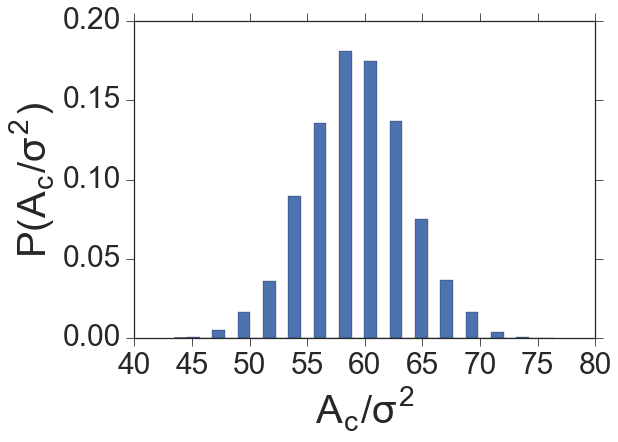

In [18]:
### set general plot properties

downlim = -2
uplim = lx+2
num_ticks = 5
ax_len = 1.0                          # Length of one subplot square box
ax_b = 0.0                            # Beginning/offset of the subplot in the box
ax_sep = 0.0                          # Separation length between two subplots
total_subplots_in_x = 1               # Total number of subplots    
fig = plt.figure()
subp = misc_tools.Subplots(fig, ax_len, ax_sep, ax_b, total_subplots_in_x) 
ax0 = subp.addSubplot()

### plot 

line0 = ax0.hist(areas, bins=30, normed=True)

#ax0.axvline(constants['fp=1.0'].tau_R/constants['fp=1.0'].tau_D, color='black')

### labels

ax0.set_xlabel(r"$A_c/\sigma^2$", fontsize=40)
ax0.set_ylabel(r"$P(A_c/\sigma^2)$", fontsize=40)

### limits

#ax0.set_xlim((-1, 3.0))
#ax0.set_ylim((-0.2, 3.0))

### ticks

#ax0.xaxis.set_ticks(np.linspace(0, uplim, num_ticks, endpoint=True))
#ax0.yaxis.set_ticks(np.linspace(0, uplim, num_ticks, endpoint=True))
ax0.tick_params(axis='both', which='major', labelsize=30)

### legend

ax0.legend(bbox_to_anchor=(0.05, 0., 0.65, 1.0), loc=2, borderaxespad=0., \
    prop={'size': 20}, mode="expand", frameon=False)
    
### save

savepath = "area_histogram.pdf"          
plt.savefig(savepath, dpi=300, bbox_inches='tight', pad_inches=0.08)

In [19]:
print "Density of the system is : " + str(np.sum(areas)/lx/ly)
print "Number density of the system is : " + str(nbeads/lx/ly)

Density of the system is : 1.51841436166
Number density of the system is : 1.01657273835


Little bit of clarification on notation:

- x, y: Unwrapped coordinates of beads
- xi, yi: Wrapped coordinates of beads inside the central simulation box
- xip, yip: Wrapped coordinates of beads inside the central simulation box that is SORTED according to their corresponding bond order inside a cell
- xcom, ycom: Wrapped center of mass coordinates of cells inside the central simulation box
- xpc, ypc: Wrapped coordinates of cells inside the central simulation box with each cell keeping a list of its beads coordinates
- xpbc, ypbc: Just like xpc and ypc, but corrected for periodic boundary conditions

In [53]:
def sort_beads(xi, yi, nbeads, bid, cid):
    """ sort bead positions based on the cell identities of beads"""
    
    xip = np.zeros((nbeads), dtype=np.float32)
    yip = np.zeros((nbeads), dtype=np.float32)
    k = 0
    for n in xrange(ncells):
        idx = np.sort(bid[cid==n])
        for i in idx:
            xip[k] = xi[bid==i]
            yip[k] = yi[bid==i]
            k += 1     
            
    return xip, yip

In [20]:
def coords_per_cells(x, y, nbpc):
    """ get the coordinates of beads in terms of cells"""
    
    splitter = np.cumsum(nbpc)[:-1]
    x_per_cell = np.split(x, splitter)
    y_per_cell = np.split(y, splitter)
    
    return x_per_cell, y_per_cell

In [21]:
def calc_com_of_cells(xpc, ypc, lx, ly):
    """ calculate the center of mass of cells
    note that calculation is over unwrapped coordinates of beads
    and coms are wrapped back into the central box"""
    
    xcom = np.array([np.mean(posarr) for posarr in xpc])
    xcom -= np.floor(xcom/lx)*lx
    ycom = np.array([np.mean(posarr) for posarr in ypc])
    ycom -= np.floor(ycom/ly)*ly
    
    return xcom, ycom

In [22]:
def pbc_dist_around_com(x1, x2, lx):
    """ correct the periodic boundary corrected distance between the positions x1-x2"""
    
    dx = x1-x2 
    
    if dx > lx/2.:
        dx = -lx
    elif dx < -lx/2.:
        dx = lx
    else:
        dx = 0.
        
    return dx

In [54]:
def correct_pbc_around_com(xi, yi, xcom, ycom, nbeads, ncells, nbpc, lx, ly):
    """ correct bead positions according to cell center of mass positions"""
    
    xpbc = np.zeros((nbeads), dtype=np.float32)
    ypbc = np.zeros((nbeads), dtype=np.float32)
    
    k = 0
    for n in xrange(ncells):
        for j in xrange(nbpc[n]):
            dx = pbc_dist_around_com(xi[k], xcom[n], lx)
            dy = pbc_dist_around_com(yi[k], ycom[n], ly)
            xpbc[k] = xi[k] + dx
            ypbc[k] = yi[k] + dy
            xi[k] += dx
            yi[k] += dy
            k += 1
        
    return xpbc, ypbc

In [24]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.collections import PolyCollection

In [25]:
xpc, ypc = coords_per_cells(x, y, nbpc)

In [55]:
xcom, ycom = calc_com_of_cells(xpc, ypc, lx, ly)
#plt.scatter(xi, yi, s=0.5, c='g', alpha=0.3)
#plt.scatter(xcom, ycom, s=0.5, c='b',alpha=1.0)
#plt.axis('equal')
#plt.savefig("debug.png", dpi=300, bbox_inches='tight', pad_inches=0.08)

In [56]:
xpbc, ypbc = correct_pbc_around_com(xi, yi, xcom, ycom, nbeads, ncells, nbpc, lx, ly)

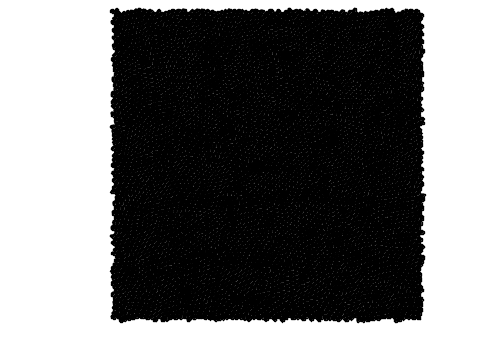

In [123]:
ax_len = 1.0                          # Length of one subplot square box
ax_b = 0.0                            # Beginning/offset of the subplot in the box
ax_sep = 0.0                          # Separation length between two subplots
total_subplots_in_x = 1               # Total number of subplots    
fig = plt.figure()
subp = misc_tools.Subplots(fig, ax_len, ax_sep, ax_b, total_subplots_in_x) 
ax0 = subp.addSubplot()

patches = []
k = 0
for n in range(ncells):
    r = np.vstack((xpbc[k:k+nbpc[n]]/0.5, ypbc[k:k+nbpc[n]]/0.5)).T
    k += nbpc[n]
    polygon = Polygon(r, True)
    patches.append(polygon)
    
p = PatchCollection(patches, facecolor='black', alpha=1.0)

ax0.add_collection(p)
ax0.autoscale_view()

ax0.scatter(xi/0.5, yi/0.5, s=1.0, c='black', alpha=1.0)

ax0.axis('equal')
ax0.set_xlim((-10, lx/0.5+10))
ax0.set_ylim((-10, ly/0.5+10))
ax0.axis('off')

savepath = "area_polygons.png"          
plt.savefig(savepath, dpi=300, bbox_inches='tight', pad_inches=0.0)

In [124]:
import PIL
from PIL import Image

In [125]:
im = Image.open("area_polygons.png")
print im

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=2043x1412 at 0x1196C5110>


In [146]:
bim = im.convert('1') 
bim.save('area_polygons_bw.png')

In [147]:
bimd = np.ravel(np.asarray(bim))

In [154]:
print float(len(bimd[bimd==False]))/float(len(bimd))
print float(len(bimd[bimd==True]))/float(len(bimd))

0.579456695217
0.420543304783
